# UWB Pose prediction signal processing EDA + ResNet

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

SEED = 1999
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [6]:
class_meanings = pd.read_csv('/kaggle/input/ultra-wide-band-pose-prediction/classes.csv', index_col=0).to_dict()['class']
class_meanings

{0: 'ล้ม (เป็นลม/สะดุด)',
 1: 'กระโดด',
 2: '(ตั้งใจ) ลงไปนอนบนที่นอน',
 3: 'วิ่ง',
 4: 'จากยืน/เดินลงไปนั่ง',
 5: 'จากนั่งลุกขึ้นมายืน/เดิน',
 6: 'เดิน'}

In [7]:
train_df = pd.read_csv('/kaggle/input/ultra-wide-band-pose-prediction/annotations.csv')
train_df.value_counts('class').sort_index()

class
0     50
1     99
2     43
3    111
4    116
5    107
6    121
Name: count, dtype: int64

In [10]:
train_dir = Path('/kaggle/input/ultra-wide-band-pose-prediction/train/train') # 647
train_paths = list(train_dir.rglob('*.npy'))

shapes = {}

for i, file in enumerate(train_paths):
    shape = np.load(file).shape
    shapes[shape] = shapes.get(shape, 0) + 1

shapes

{(2560, 56): 646, (7680, 56): 1}

In [11]:
def load(file) -> np.array:
    return np.load(file)[-2560:, :]

In [12]:
def plot(file: Path, transform=None) -> None:
    file = load(file)
    if transform:
        file = transform(file)
    fig, axs = plt.subplots(3, constrained_layout=True)
    axs[0].set_title('Amplitude')
    axs[0].imshow(np.abs(file.T), aspect='auto')
    axs[1].set_title('Phase Angle')
    axs[1].imshow(np.angle(file.T), aspect='auto')
    axs[2].set_title('Amplitude against Phase')
    axs[2].scatter(np.abs(file.mean(axis=1)), np.angle(file.mean(axis=1)))
    plt.show()

In [13]:
# Sample image for each class
sample_df = train_df.iloc[train_df['class'].drop_duplicates().index].sort_values('class')
sample_df

,id,class
0,80a8dc1d-b216-469c-91b1-fc257562a883,0
321,f90220e2-801e-4dbe-b200-6af1b749022f,1
157,bc0da466-5582-424a-8014-b37d99f51704,2
420,df8ba91b-adc0-4903-b915-343838da8e55,3
531,ef78a557-6858-40f7-992e-d224be7c0bd4,4
50,84d72864-042f-4b27-9acf-3d0dce3edd73,5
200,5d06825e-7a3d-4878-b0be-e23a35d4c5ef,6


Class 0, ล้ม (เป็นลม/สะดุด)


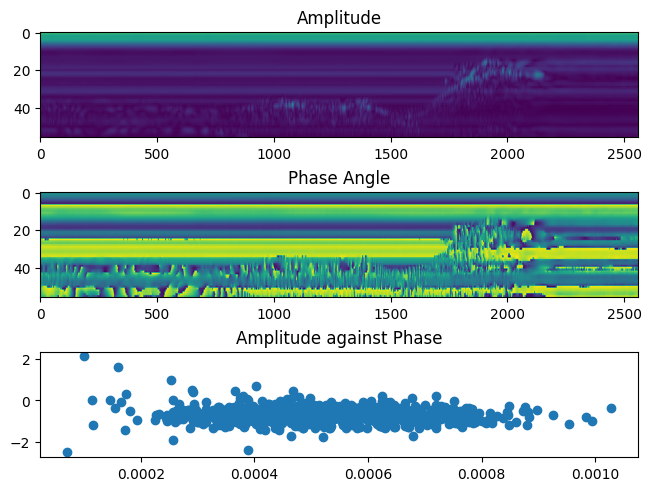

Class 1, กระโดด


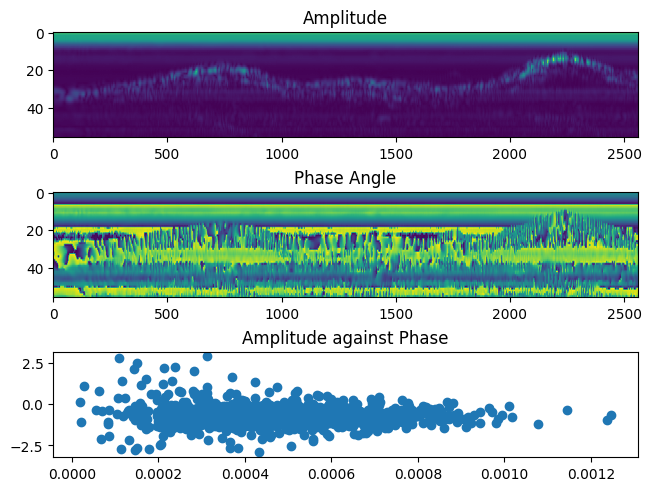

Class 2, (ตั้งใจ) ลงไปนอนบนที่นอน


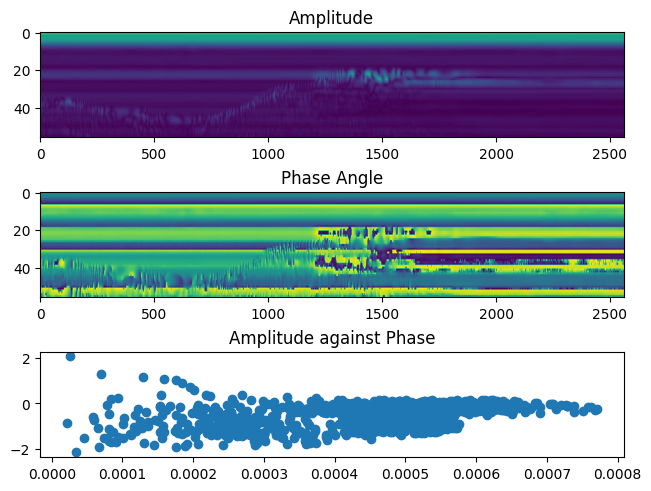

Class 3, วิ่ง


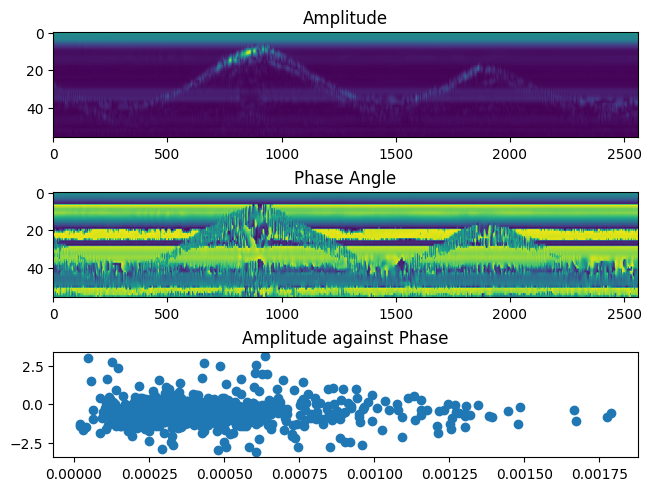

Class 4, จากยืน/เดินลงไปนั่ง


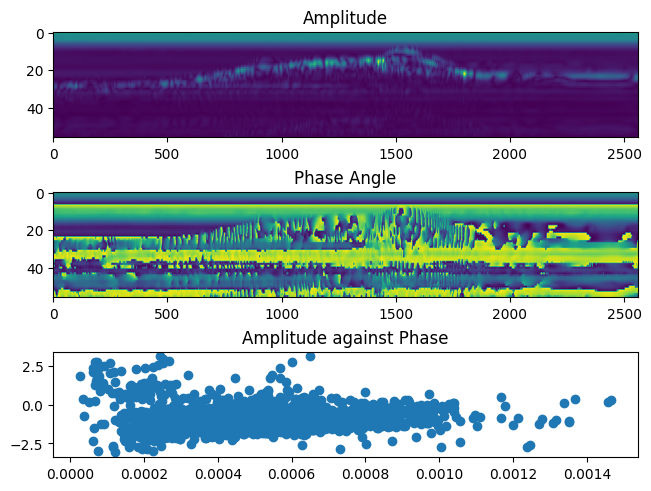

Class 5, จากนั่งลุกขึ้นมายืน/เดิน


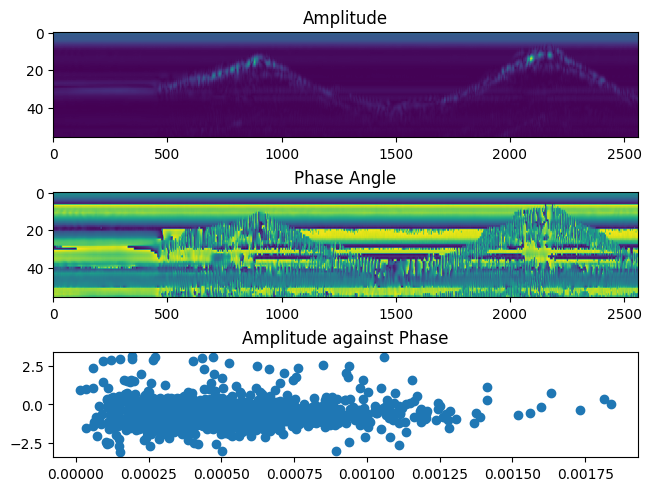

Class 6, เดิน


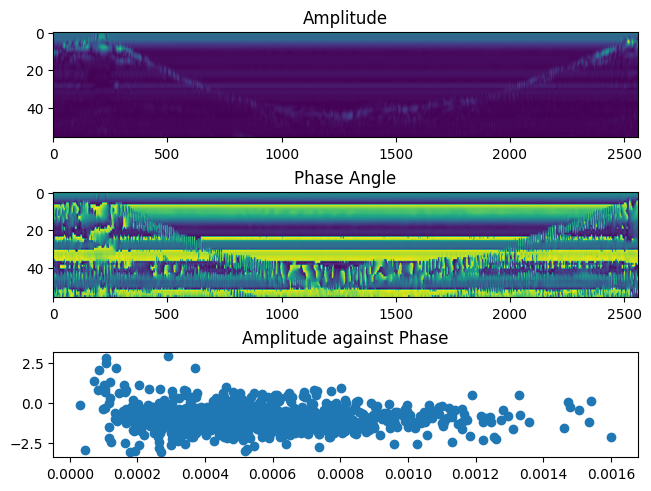

In [14]:
for _, (stem, y) in sample_df.iterrows():
    print(f'Class {y}, {class_meanings[y]}')
    plot((train_dir / stem).with_suffix('.npy'))

In [15]:
def preprocess_signal(signal):

    # Extract magnitude and phase
    magnitude = np.abs(signal)
    phase = np.angle(signal)
    
    # Feature concatenation (magnitude + phase)
    features = np.concatenate((magnitude, phase), axis=1)
    
    # Normalization
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    
    result = normalized_features
    
    return result

Class 0, ล้ม (เป็นลม/สะดุด)


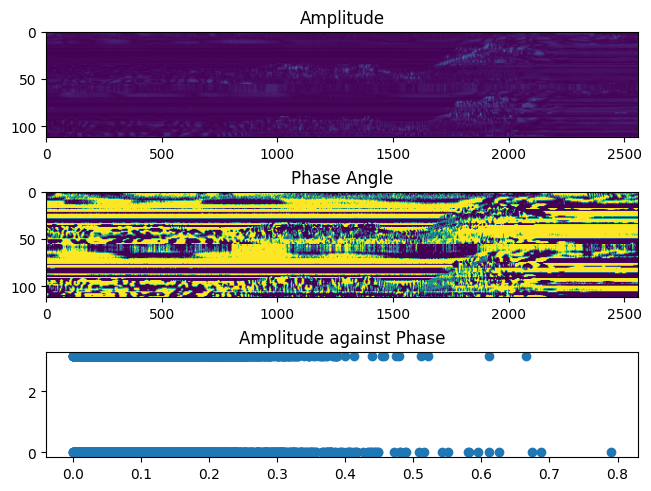

Class 1, กระโดด


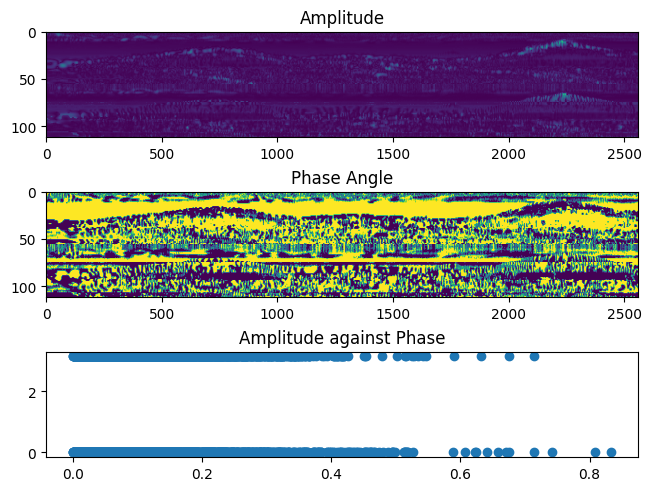

Class 2, (ตั้งใจ) ลงไปนอนบนที่นอน


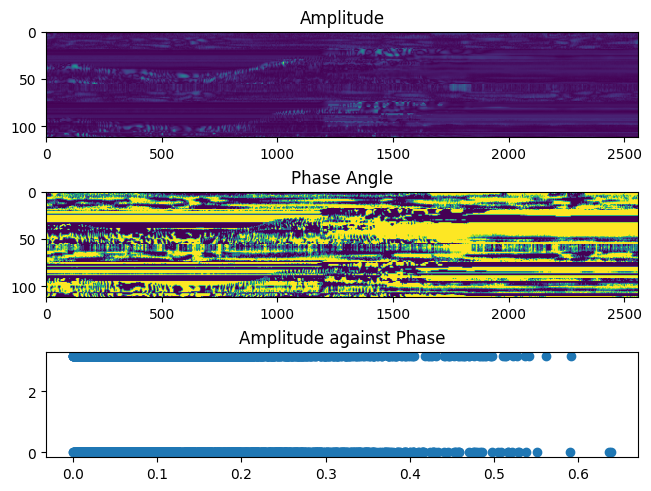

Class 3, วิ่ง


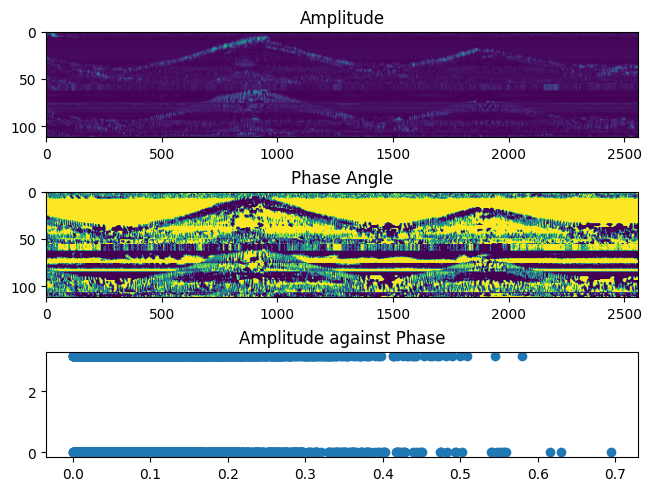

Class 4, จากยืน/เดินลงไปนั่ง


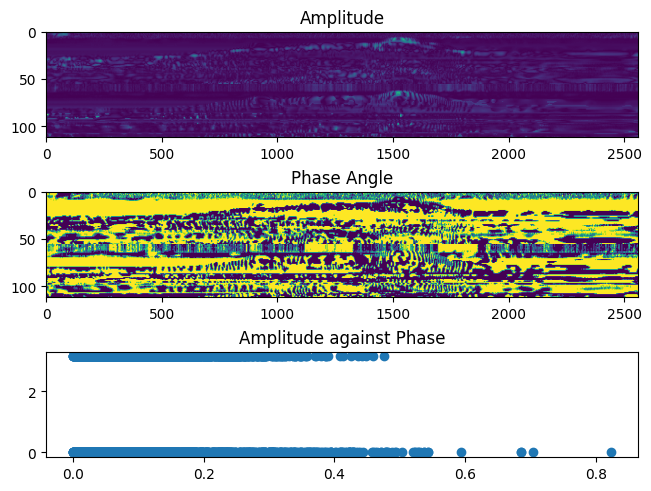

Class 5, จากนั่งลุกขึ้นมายืน/เดิน


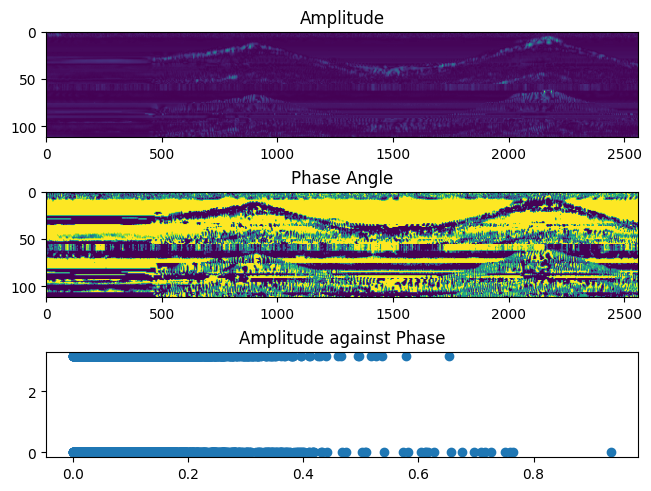

Class 6, เดิน


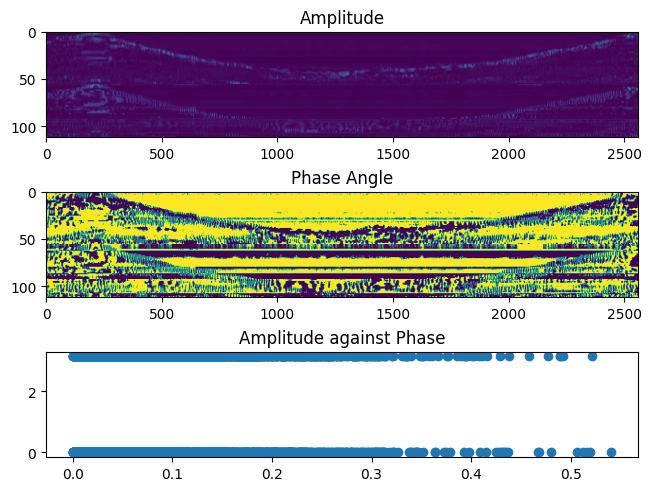

In [16]:
for _, (stem, y) in sample_df.iterrows():
    print(f'Class {y}, {class_meanings[y]}')
    plot((train_dir / stem).with_suffix('.npy'), transform=preprocess_signal)

Try to classify as image, on both raw and preprocessed images.

In [17]:
def numpy_array_to_pil_image(arr):
    arr_normalized = (arr - arr.min()) / (arr.max() - arr.min()) * 255
    
    arr_uint8 = arr_normalized.astype(np.uint8)
    
    image = Image.fromarray(arr_uint8)
    
    return image

In [24]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, load_fn=load, convert_fn=numpy_array_to_pil_image):
        self.dataframe = dataframe
        self.transform = transform
        self.load_fn = load_fn
        self.convert_fn = convert_fn

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = self.convert_fn(self.load_fn((train_dir / img_name).with_suffix('.npy'))).convert('RGB')  # Convert grayscale to RGB for ResNet
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataset
full_dataset = ImageDataset(dataframe=train_df, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Load a pretrained ResNet model and modify it for 7 classes
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 7)  # Adjusting for 7 classes

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

# Training and validation loop
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    resnet50.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy and F1 score
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, "
          f"Validation Accuracy: {val_accuracy}, Validation F1: {val_f1}")


Epoch 1, Loss: 1.8104825973510743, Validation Accuracy: 0.4230769230769231, Validation F1: 0.3465827744293218
Epoch 2, Loss: 1.428977465400329, Validation Accuracy: 0.6153846153846154, Validation F1: 0.5959991888938411
Epoch 3, Loss: 0.9815070870977182, Validation Accuracy: 0.6307692307692307, Validation F1: 0.6336962593455377
Epoch 4, Loss: 0.937665913024774, Validation Accuracy: 0.6076923076923076, Validation F1: 0.6164565996663183
Epoch 5, Loss: 0.7728715069305439, Validation Accuracy: 0.6923076923076923, Validation F1: 0.6916820663056482
Epoch 6, Loss: 0.6139690045553904, Validation Accuracy: 0.7153846153846154, Validation F1: 0.7161828469520777
Epoch 7, Loss: 0.40402105671281996, Validation Accuracy: 0.7384615384615385, Validation F1: 0.7395214286806416
Epoch 8, Loss: 0.34188430820269367, Validation Accuracy: 0.7769230769230769, Validation F1: 0.7775477055610447
Epoch 9, Loss: 0.3543154356965365, Validation Accuracy: 0.7307692307692307, Validation F1: 0.7323639704826714
Epoch 10, 

# v2 retrain with all training data

In [70]:
# Data loaders
all_loader = DataLoader(train_dataset + val_dataset, batch_size=4, shuffle=True)

# Load a pretrained ResNet model and modify it for 7 classes
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 7)  # Adjusting for 7 classes

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

# Training and validation loop
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    for inputs, labels in all_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate accuracy and F1 score
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 2.268978370152987
Epoch 2, Loss: 1.5668443494118176
Epoch 3, Loss: 1.1644443879333826
Epoch 4, Loss: 0.896814511085932
Epoch 5, Loss: 0.8139504968690184
Epoch 6, Loss: 0.6862109604649819
Epoch 7, Loss: 0.5702898874914704
Epoch 8, Loss: 0.4284676101640798
Epoch 9, Loss: 0.3041655825361466
Epoch 10, Loss: 0.3316233674941871
Epoch 11, Loss: 0.23926463170568102
Epoch 12, Loss: 0.30137037742130746
Epoch 13, Loss: 0.41658751155572155
Epoch 14, Loss: 0.20711930727613015
Epoch 15, Loss: 0.208109156255467
Epoch 16, Loss: 0.15816563794908758
Epoch 17, Loss: 0.08766590212471784
Epoch 18, Loss: 0.09812196448933369
Epoch 19, Loss: 0.136733247475618
Epoch 20, Loss: 0.14718633105557483
Epoch 21, Loss: 0.11912635490925123
Epoch 22, Loss: 0.10108634830830851
Epoch 23, Loss: 0.07546081178577599
Epoch 24, Loss: 0.12303451106832095
Epoch 25, Loss: 0.07726727985573234
Epoch 26, Loss: 0.04399814284854354
Epoch 27, Loss: 0.03833823676658749
Epoch 28, Loss: 0.10162370182280518
Epoch 29, Loss: 0

In [71]:
test_dir = Path('/kaggle/input/ultra-wide-band-pose-prediction/test/test/')
sample_sub = pd.read_csv('/kaggle/input/ultra-wide-band-pose-prediction/sample_submission.csv')

resnet50.eval()
resnet50 = resnet50.cpu()
with torch.inference_mode():
    for i, (stem, truth) in sample_sub[3:].iterrows():
        path = (test_dir / stem).with_suffix('.npy')
        output = resnet50(transform(numpy_array_to_pil_image(load(path)).convert('RGB')).unsqueeze(0))
        pred = torch.max(output, 1).indices.item()
        sample_sub.iloc[i, 1] = pred

sample_sub

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,6.0
1,84e55af1-ae63-4b06-b650-1136d38b691e,4.0
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,2.0
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,4.0
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,0.0
...,...,...
159,5fce955d-1068-40b3-afc3-111f8c22c9f9,3.0
160,f3a000be-07c9-44ad-8ff0-b89a9a1070dd,4.0
161,84d3963b-cfed-450c-88ab-ca853273d15c,1.0
162,7b36184c-5541-44d9-9200-8057bd3cf4ef,6.0


In [72]:
sample_sub.to_csv('/kaggle/working/submission.csv', index=False)